<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Angeli(2004).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection of multistability, bifurcations, andhysteresis in a large class of biologicalpositive-feedback systems**

### David Angeli, James E. Ferrell, Jr., and Eduardo D. Sontag

---

En este notebook se busca replicar los resultados mostrados en el artículo señalado en el título. 

También se puede encontrar en la siguiente liga: [Angeli(2004)](https://www.pnas.org/doi/full/10.1073/pnas.0308265100)


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

mpl.rcParams['figure.figsize'] = (14,6)

En el artículo se realiza un análisis del sistema **Cdc2-cyclin B/Wee1** como ejemplo para mostrar la propuesta de un método numérico para sistemas que no tienen solución analítica.

\begin{align}
    \dot{x_1} &= \alpha_1x_2 - \frac{\beta_1x_1(\nu y_1)^{\gamma_1}}{K_1+(\nu y_1)^{\gamma_1}},\qquad &\dot{x_2} &= -\alpha_1x_2 + \frac{\beta_1x_1(\nu y_1)^{\gamma_1}}{K_1+(\nu y_1)^{\gamma_1}}\\
    \dot{y_1} &= \alpha_2y_2 - \frac{\beta_2y_1 x_1^{\gamma_2}}{K_2+ x_1^{\gamma_2}},\qquad &\dot{y_2} &= -\alpha_2y_2 + \frac{\beta_2y_1x_1^{\gamma_2}}{K_2+x_1^{\gamma_2}}
\end{align}


donde $x_1$ es el estado activo de la ciclina **Cdc2** y $y_1$ es el estado activo de **Wee1**, además $\alpha$, $\beta$, $\gamma$, $K$ son constantes del sistema.

Ahora para simplificar nuestro sistemas consideramos un sistema constante de Cdc2 y Wee1 (se mantienen constantes el total de los estados activos e inactivos de cada uno de los componentes), podemos reducir el sistema anterior en solamente 2 ecuaciones:

\begin{align}
    \dot{x_1} &= \alpha_1(1-x_1) - \frac{\beta_1x_1(\nu y_1)^{{\gamma_1}}}{K_1+(\nu y_1)^{\gamma_1}},\qquad 
    &\dot{y_1} &= \alpha_2(1-y_1) - \frac{\beta_2y_1 x_1^{\gamma_2}}{K_2+ x_1^{\gamma_2}}
\end{align}

---

### Diagrama fase para el sistema **Cdc2-cyclin B/Wee1**.
#### *Deducido de soluciones numéricas*

In [47]:
# primero definimos los parámetros dados en el artículo 
a1, a2 = 1, 1
b1, b2= 200, 10;
gamma1, gamma2 = 4, 4
k1, k2 = 30, 1;
V = np.array([1, 1.9, 0.75])

# escribimos las ecuaciones en una función
f_x = lambda x, y: a1*(1-x) - (b1*x*(nu*y)**gamma1)/(k1 + (nu*y)**gamma1)
f_y = lambda x, y: a2*(1-y) - (b2*y*x**gamma2)/(k2 + y**gamma2)

# se reunen las ecuaciones individuales en una función para vectorizar el proceso
def dX(X):
    x, y = X
    dx = f_x(x, y);
    dy = f_y(x, y);
    return np.array([dx, dy])

In [46]:
# se utilizará Runge-Kutta 4 como resolvedor del sistema de ecuaciones diferenciales 
def RK_solver(X0, dX, t):
    dims = len(X0)
    K = np.empty([4, dims])
    X = np.empty([len(t)+1, dims])
    
    for d in range(dims):   
        X[0, d] = X0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        K[0] = dt * dX(X[i]) 
        K[1] = dt * dX(X[i] + K[0]/2)
        K[2] = dt * dX(X[i] + K[1]/2)
        K[3] = dt * dX(X[i] + K[2]  )
        for d in range(dims):
            X[i+1, d] = X[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    X = X[0:-1,:]
    return X

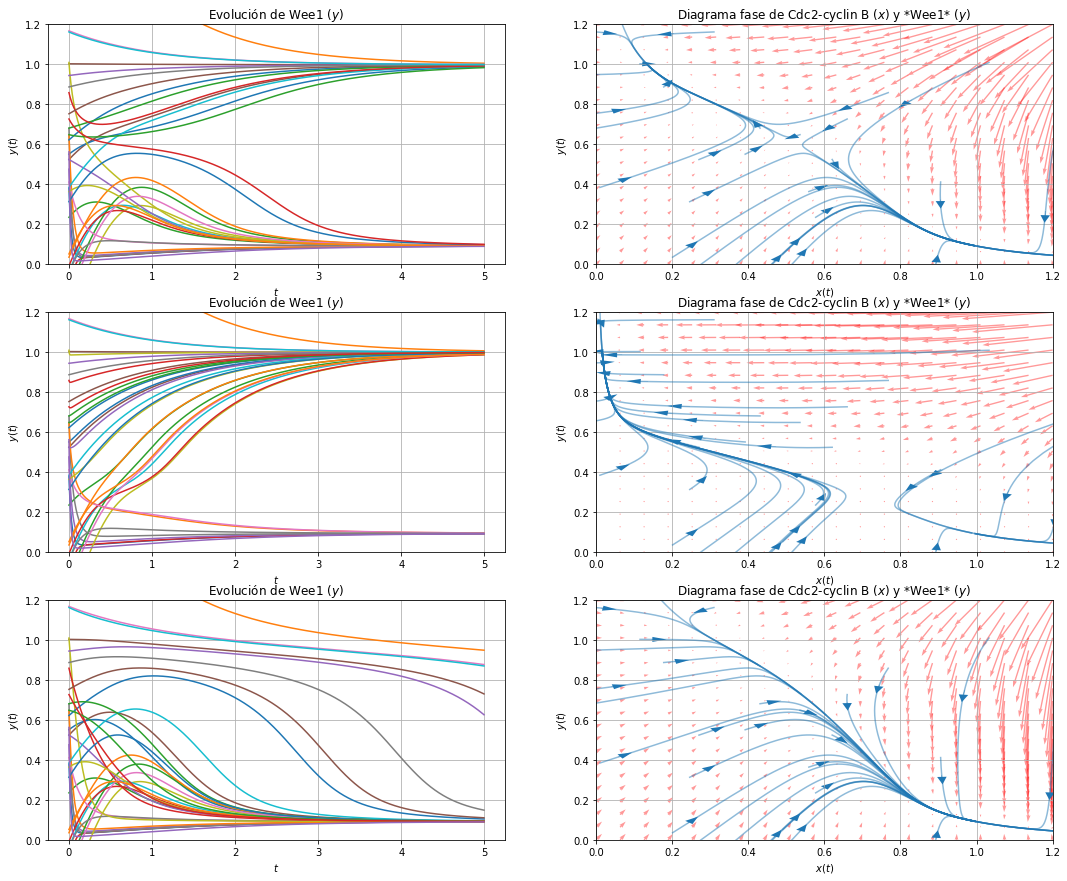

In [70]:
# se establece un rango de tiempo de 0 a 5 (segundos)
start=0; step=0.005; num=1000
T = np.arange(0, num)*step+start

mu, sigma = 0.5, 0.45 # mean and standard deviation
X0 = np.random.normal(mu, sigma, size=(35, 2))
num_xy = 20

fig, ax = plt.subplots(3,2, gridspec_kw=dict(width_ratios=[1,1]), figsize=(18,15))
for k in range(len(V)):
    S = []; nu = V[k]
    for i in range(len(X0)):
        S.append(RK_solver(X0[i], dX, T))

    for i in range(len(S)):
        # print(ax[0,0])
        ax[k,0].plot(T,S[i][:,1])
    ax[k,0].set_title(r"Evolución de Wee1 ($y$)")
    ax[k,0].set_xlabel("$t$"); ax[k,0].set_ylabel("$y(t)$");
    ax[k,0].set_ylim([0, 1.2]); ax[k,0].grid();

    x, y = np.linspace(0,1.2, num_xy), np.linspace(0,1.2, num_xy)
    x, y = np.meshgrid(x, y)
    ax[k,1].quiver(x,y,
                (a1*(1-x) - (b1*x*(nu*y)**gamma1)/(k1 + (nu*y)**gamma1)),
                (a2*(1-y) - (b2*y*x**gamma2)/(k2 + y**gamma2)),
                alpha = 0.4, color="red")

    for i in range(len(S)):
        ax[k,1].plot(S[i][:,0], S[i][:,1], linewidth=1.5, color="tab:blue", alpha = 0.5)
        ax[k,1].arrow(S[i][num_xy//2,0], S[i][num_xy//2,1], S[i][num_xy//2+1,0]-S[i][num_xy//2,0], S[i][num_xy//2+1,1]-S[i][num_xy//2,1], 
                    linewidth=3, color="tab:blue", lw=0, head_width=.025)

    ax[k,1].set_xlim([0, 1.2]); ax[k,1].set_ylim([0, 1.2])
    ax[k,1].set_title(r"Diagrama fase de Cdc2-cyclin B ($x$) y *Wee1* ($y$)")
    ax[k,1].set_xlabel("$x(t)$"); ax[k,1].set_ylabel("$y(t)$");
# ax[1].legend(); 
    ax[k,1].grid(); 
plt.show()

---

### Análisis de la estabilidad global de la ciclina B-Cdc2 y Wee1: 
#### _Método de "__loop abierto__"._

Este acercamiento a partir de "_loop abierto_" consiste en encontrar en la red del sistema un loop cerrado donde exista retroalimentación de manera cíclica, después se __rompe__ dicho loop y se convierte en una red donde existe una entrada ($\omega$) y una salida ($\eta$).

Para hacer una analogía de este método debemos considerar que estamos solamente en puntos de equilibrio, de tal modo que $\omega\approx \nu$ por lo que se puede medir la sensibilidad del sistema como un estímulo.

\begin{align}
    \omega \to x_1 \to y_1 \to \eta
\end{align}

En el caso del sistema ciclina B Cdc2/Wee1 tenemos lo siguiente al considerar que $\omega \to \nu y_1$.

\begin{align}
    \dot{x_1}(x_1, \omega) &= \alpha_1(1-x_1) - \frac{\beta_1x_1\omega^{{\gamma_1}}}{K_1+\omega^{\gamma_1}},\qquad 
    &\dot{y_1}(x_1, y_1) &= \alpha_2(1-y_1) - \frac{\beta_2y_1 x_1^{\gamma_2}}{K_2+ x_1^{\gamma_2}}
\end{align}

Entonces si consideramos $g_x(x_1,\omega)=\dot{x_1}=0$, y también $g_y(x_1,y_1)=\dot{y_1}=0$ podemos resolver para $x_1$ y $y_1$ respectivamente de tal manera que tengamos funciones de $\omega$ y $x_1$


\begin{align}
    \hat{x_1} = G_x(\omega),\qquad \hat{y_1} = G_y(x_1)
\end{align}

tales que:

$$ \eta(\omega) =G_y(\hat{x_1})= G_y(G_x(\omega)),\qquad \eta\approx \omega $$


Con ayuda de _Mathematica_ se obtiene el siguiente resultado para $\eta$.

\begin{align}
    \eta(\omega) = \frac{\left(\omega^4+30\right)^4+\left(201\omega ^4+ 30\right)^4}{11   \left(\omega^4+30\right)^4 + 81 \left(67\omega ^4+10\right)^4}
\end{align}

---

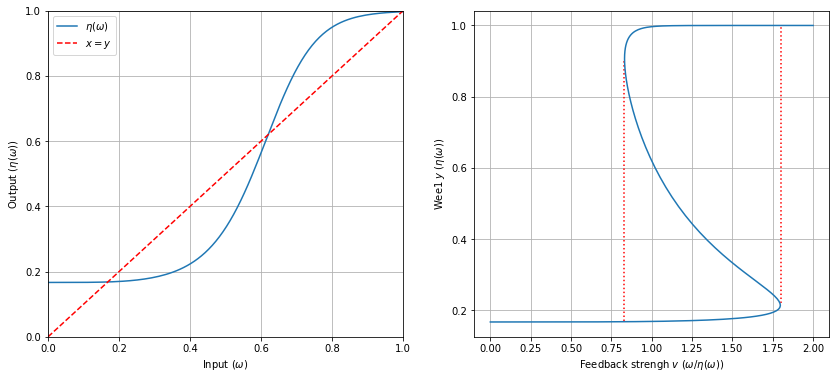

In [133]:
Omega = np.linspace(0, 2, 200);
V = np.linspace(0, 2, 200);
Eta, K_n = np.empty(len(Omega)), np.empty(len(Omega))

# definimos eta en función de omega 
def eta(omega):
    t1 = omega**4
    t2 = (t1 + 30)**4 + (201*t1 + 30)**4
    t3 = 11*(t1 + 30)**4 + 81*(67*t1 + 10)**4
    return t2/t3

s = 0
for i in range(len(Omega)):
    Eta[i] = eta(Omega[i])
    
fig, ax = plt.subplots(1,2, gridspec_kw=dict(width_ratios=[1,1]), figsize=(14,6))
ax[0].plot(Omega, Eta, label="$\eta(\omega)$"); 
ax[0].plot(Omega, Omega, "r--", label="$x=y$")
ax[0].grid(); ax[0].legend()
ax[0].set_xlabel("Input ($\omega$)"); ax[0].set_ylabel("Output ($\eta(\omega)$)")
ax[0].set_xlim([0,1]); ax[0].set_ylim([0,1])

ax[1].plot(Omega/Eta, Eta, label="$\eta(\omega)$"); 
ax[1].vlines(0.83, 0.17, 0.9, linestyles ="dotted", colors ="r")
ax[1].vlines(1.80, 0.22, 1.0, linestyles ="dotted", colors ="r")
# ax[1].plot(Omega, Omega, "r--", label="$x=y$")
ax[1].grid();
ax[1].set_ylabel("Wee1 $y$ ($\eta(\omega)$)"); ax[1].set_xlabel("Feedback strengh $v$ ($\omega/\eta(\omega)$)")
# ax[1].set_xlim([0,2]); ax[0].set_ylim([0,1])
plt.show()